# Plots for abs550aer - all models

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import datetime
import gcsfs
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import time
import xarray as xr
import zarr

### Input files

In [2]:
# UKESM

UK_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_UKESM1-0-LL_ssp370SST_r1i1p1f2_gn_201501-209912.nc'
UK_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_UKESM1-0-LL_ssp370SST-lowBC_r1i1p1f2_gn_201501-209912.nc'

print(UK_filename_base)
print(UK_filename_signal)

UKESM_base = xr.open_dataset(UK_filename_base)
UKESM_signal = xr.open_dataset(UK_filename_signal)

# MIROC6

MIR_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_MIROC6_ssp370SST_r1i1p1f1_gn_201501-209912.nc'
MIR_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_MIROC6_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

print(MIR_filename_base)
print(MIR_filename_signal)

MIROC_base = xr.open_dataset(MIR_filename_base)
MIROC_signal = xr.open_dataset(MIR_filename_signal)

# MPI-ESM

MPI_filename_base = '/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_MPI-ESM-1-2-HAM_ssp370SST_r1i1p1f1_gn_201501-205512.nc'
MPI_filename_signal = '/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_MPI-ESM-1-2-HAM_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc'

print(MPI_filename_base)
print(MPI_filename_signal)

MPI_ESM_base = xr.open_dataset(MPI_filename_base)
MPI_ESM_signal = xr.open_dataset(MPI_filename_signal)

/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_UKESM1-0-LL_ssp370SST_r1i1p1f2_gn_201501-209912.nc
/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_UKESM1-0-LL_ssp370SST-lowBC_r1i1p1f2_gn_201501-209912.nc


/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_MIROC6_ssp370SST_r1i1p1f1_gn_201501-209912.nc
/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_MIROC6_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc
/nird/home/julnavda/CMIP6/ssp370SST/abs550aer/abs550aer_AERmon_MPI-ESM-1-2-HAM_ssp370SST_r1i1p1f1_gn_201501-205512.nc
/nird/home/julnavda/CMIP6/ssp370SST-lowBC/abs550aer/abs550aer_AERmon_MPI-ESM-1-2-HAM_ssp370SST-lowBC_r1i1p1f1_gn_201501-205512.nc


In [3]:
UKESM_base

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lon: 192, lat: 144)
Coordinates:
  * time        (time) object 2015-01-16 00:00:00 ... 2099-12-16 00:00:00
  * lon         (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * lat         (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object ...
    lon_bnds    (lon, bnds) float64 ...
    lat_bnds    (lat, bnds) float64 ...
    abs550aer   (time, lat, lon) float32 ...
    wavelength  float64 ...
Attributes: (12/51)
    CDI:                        Climate Data Interface version 2.1.1 (https:/...
    source:                     UKESM1.0-LL (2018): \naerosol: UKCA-GLOMAP-mo...
    institution:                Natural Environment Research Council, STFC-RA...
    Conventions:                CF-1.7 CMIP-6.2
    activity_id:                AerChemMIP
    branch_method:              standard
    ...                         ...
    license:                    CMIP6 model data produced by the Natural Envi...
    cmor_version:               3.4.0
    CDO:                        Climate Data Operators version 2.1.1 (https:/...
    history:                    Mon Apr  3 13:21:08 2023: ncks -A -v waveleng...
    history_of_appended_files:  Mon Apr  3 13:21:08 2023: Appended file abs55...
    NCO:                        "4.5.5"

### Define functions

In [4]:
def calculate_anomaly(start_year, end_year, dataset1, dataset2):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  
    mean1 = dataset1.sel(time=slice(start_date, end_date)).mean(dim='time')
    mean2 = dataset2.sel(time=slice(start_date, end_date)).mean(dim='time')
    return mean2['abs550aer'] - mean1['abs550aer']

In [5]:
def calculate_annual_means(dataset, start_year, end_year):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"
    return dataset.sel(time=slice(start_date, end_date)).resample(time='A').mean(dim='time')

In [6]:
def calculate_seasonal_anomaly(start_year, end_year, dataset1, dataset2, season):
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-30"  

    # Filter datasets by season
    ds1_seasonal = dataset1.sel(time=slice(start_date, end_date))
    ds1_seasonal = ds1_seasonal.sel(time=ds1_seasonal['time'].dt.season == season)

    ds2_seasonal = dataset2.sel(time=slice(start_date, end_date))
    ds2_seasonal = ds2_seasonal.sel(time=ds2_seasonal['time'].dt.season == season)

    # Calculate means for the specific season
    mean1 = ds1_seasonal.mean(dim='time')
    mean2 = ds2_seasonal.mean(dim='time')

    return mean2['abs550aer'] - mean1['abs550aer']


### Intervals

In [7]:
UKESM_intervals = [(2015, 2034), (2035,2054), (2055, 2074), (2075, 2094)]
MIROC6_intervals = [(2015, 2034), (2035,2054)]
MPI_ESM_intervals = [(2015, 2034), (2035,2054)]

### Colorbar

In [8]:
V_MIN, V_MAX = -0.04, 0.04 

In [9]:
# Define colormap and normalization
cmap = plt.cm.RdBu_r
norm = mcolors.TwoSlopeNorm(vmin=V_MIN, vcenter=0, vmax=V_MAX)

### Anomalies

In [10]:
UKESM_anomalies = [calculate_anomaly(start, end, UKESM_base, UKESM_signal) for start, end in UKESM_intervals]
MIROC6_anomalies = [calculate_anomaly(start, end, MIROC_base, MIROC_signal) for start, end in MIROC6_intervals]
MPI_ESM_anomalies = [calculate_anomaly(start, end, MPI_ESM_base, MPI_ESM_signal) for start, end in MPI_ESM_intervals]

# Global

/tmp/ipykernel_1689600/3512899463.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.14, 0, 0.9, 0.95])


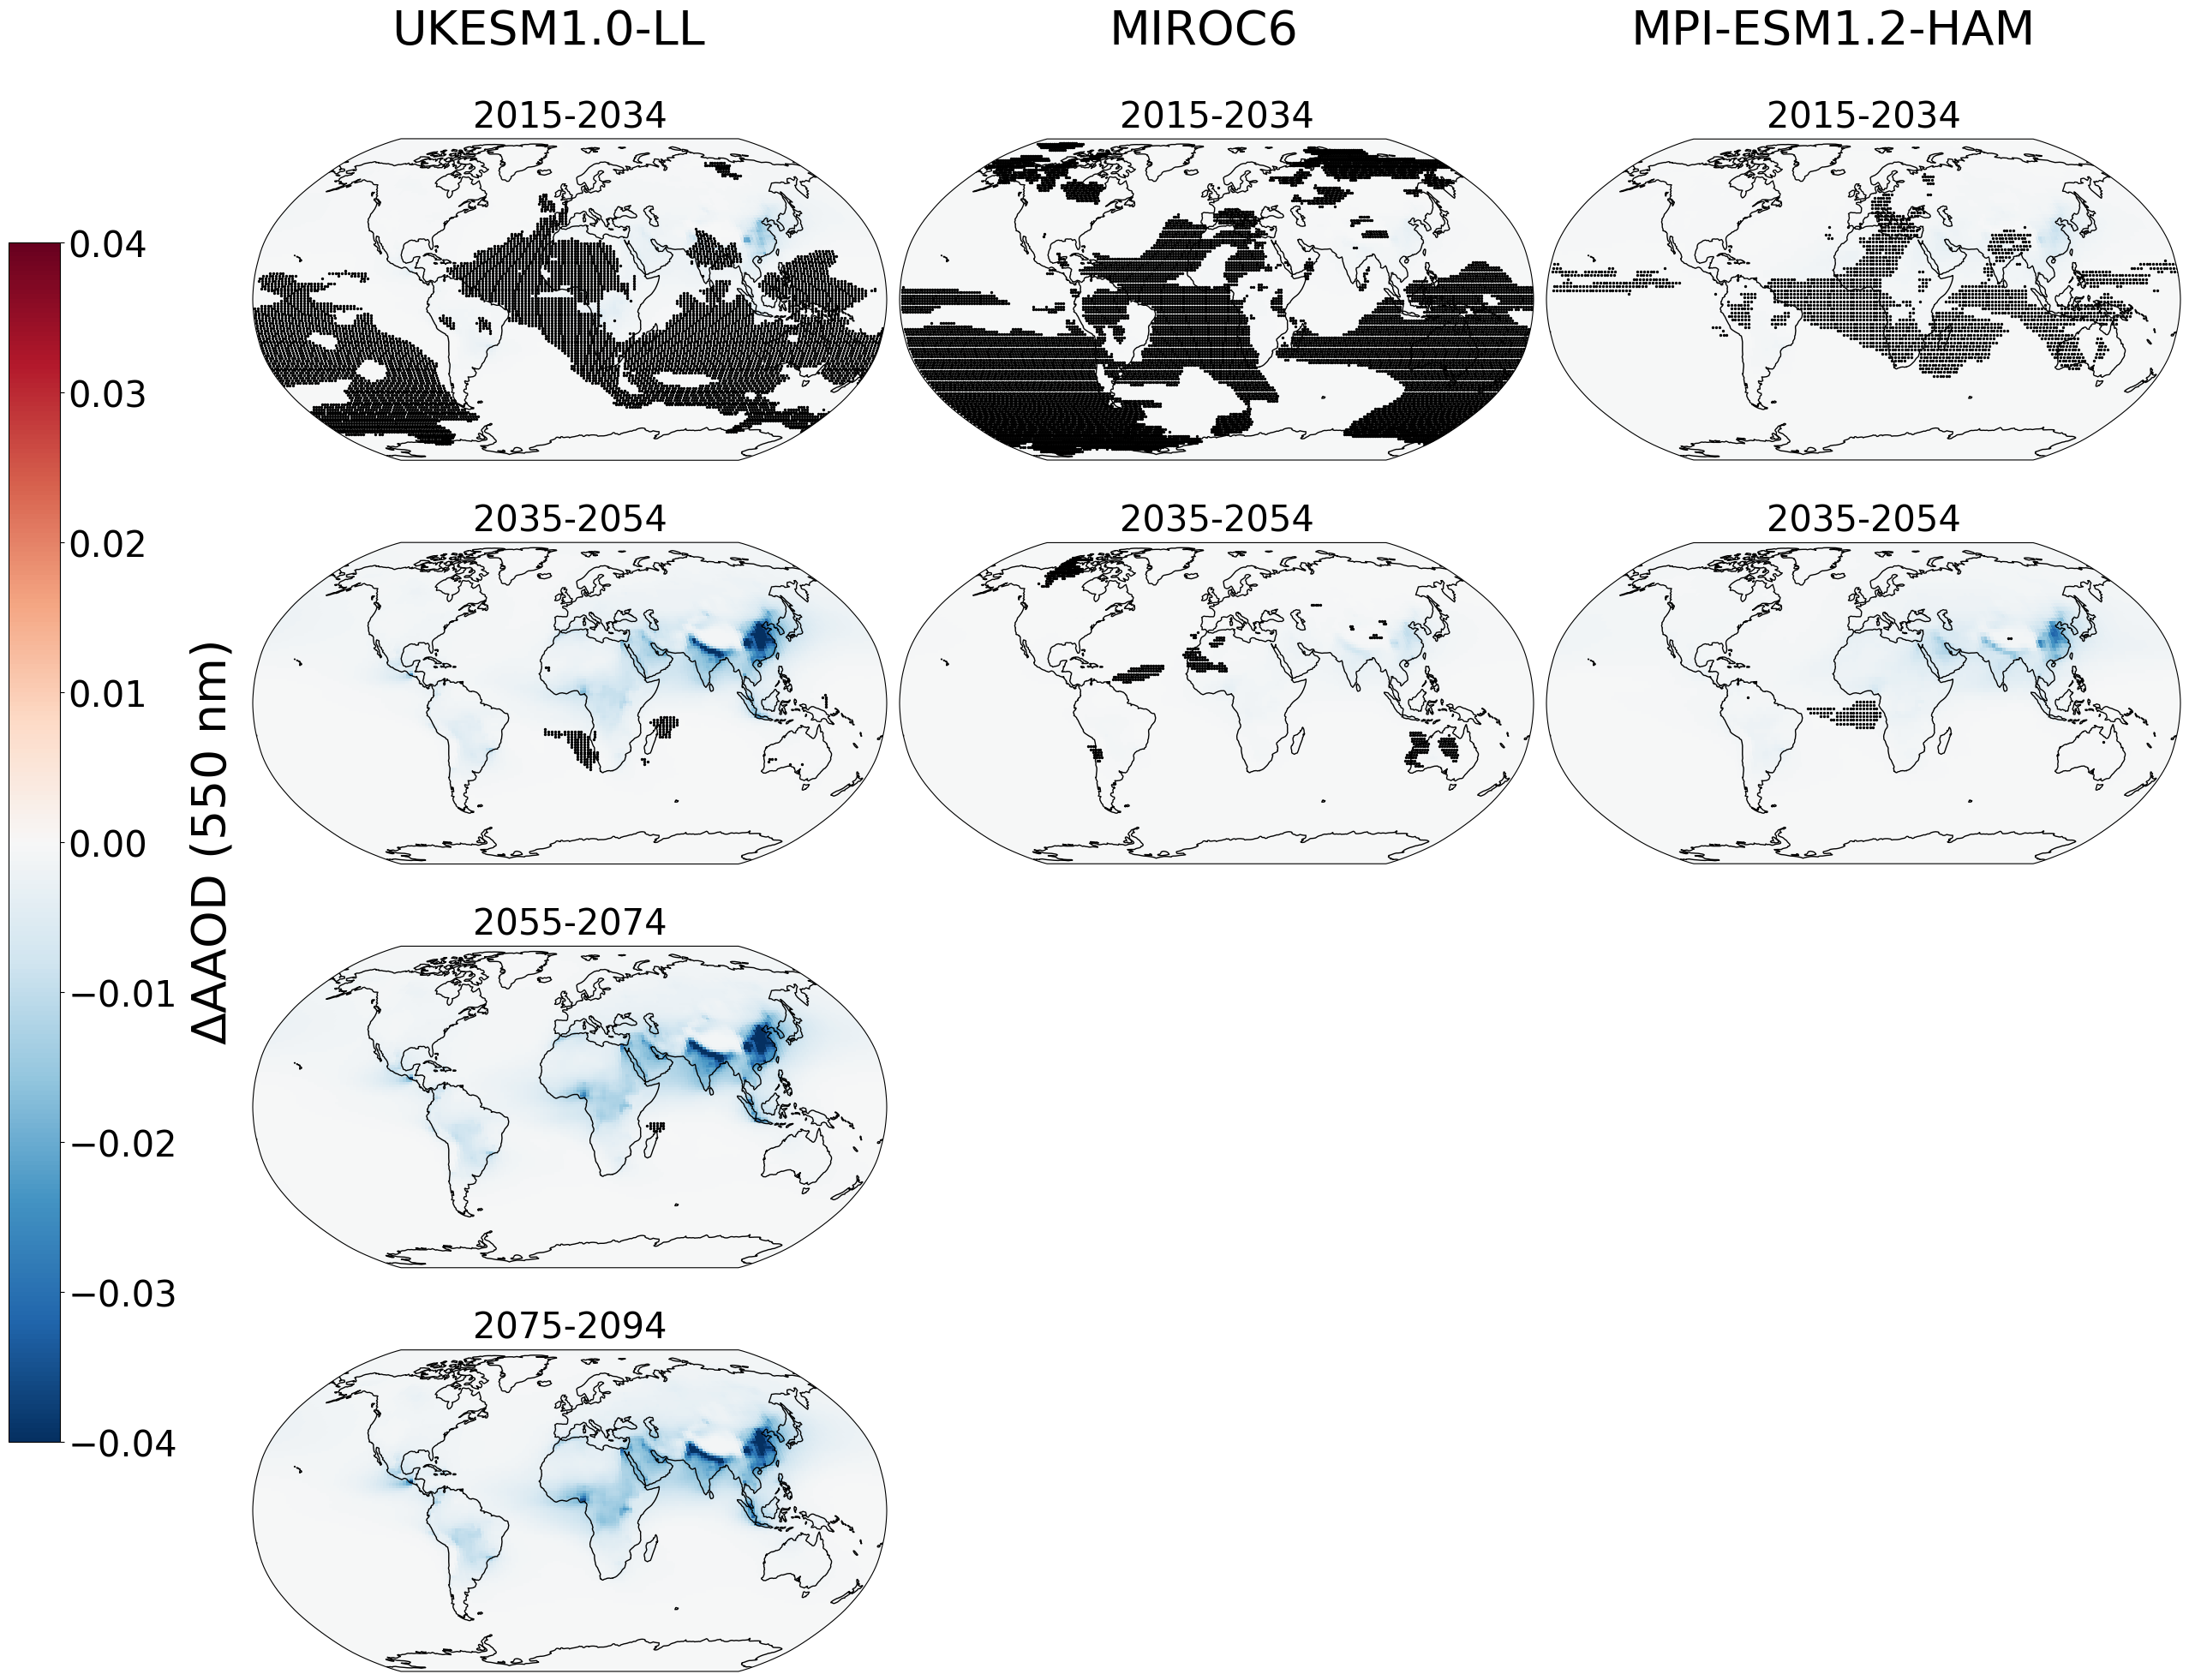

In [11]:
# Create the grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(30, 20), subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_data(ax, anomaly, title, ds_base, ds_signal, start_year, end_year):
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=30, pad=10)
    
    annual_means_base = calculate_annual_means(ds_base, start_year, end_year)
    annual_means_signal = calculate_annual_means(ds_signal, start_year, end_year)
    
    t_stat, p_value = ttest_ind(annual_means_base['abs550aer'].values,
                                annual_means_signal['abs550aer'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    non_significant_points_mask = p_value >= alpha # non-significant points

    lon, lat = np.meshgrid(annual_means_base['lon'].values, annual_means_base['lat'].values)
    ax.scatter(lon[non_significant_points_mask], lat[non_significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())
    
    return im

# Plotting for each model
last_im = None
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    last_im = plot_data(axes[0, i], UKESM_anomalies[i], f'{start_year}-{end_year}', UKESM_base, UKESM_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    last_im = plot_data(axes[1, i], MIROC6_anomalies[i], f'{start_year}-{end_year}', MIROC_base, MIROC_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    last_im = plot_data(axes[2, i], MPI_ESM_anomalies[i], f'{start_year}-{end_year}', MPI_ESM_base, MPI_ESM_signal, start_year, end_year)

# Hide empty subplots for MIROC6 and MPI-ESM
for i in range(2, 4):
    fig.delaxes(axes[1, i])
    fig.delaxes(axes[2, i])

# Create the color bar with the last image
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label(r'$\Delta$AAOD (550 nm)', labelpad=10, fontsize=40)
    
# Add headers for each model
header_fontsize = 40
fig.text(0.26, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.515, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.14, 0, 0.9, 0.95])

plt.show()

# South and East Asia

/tmp/ipykernel_1689600/4036163510.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.11, 0, 0.9, 0.95])


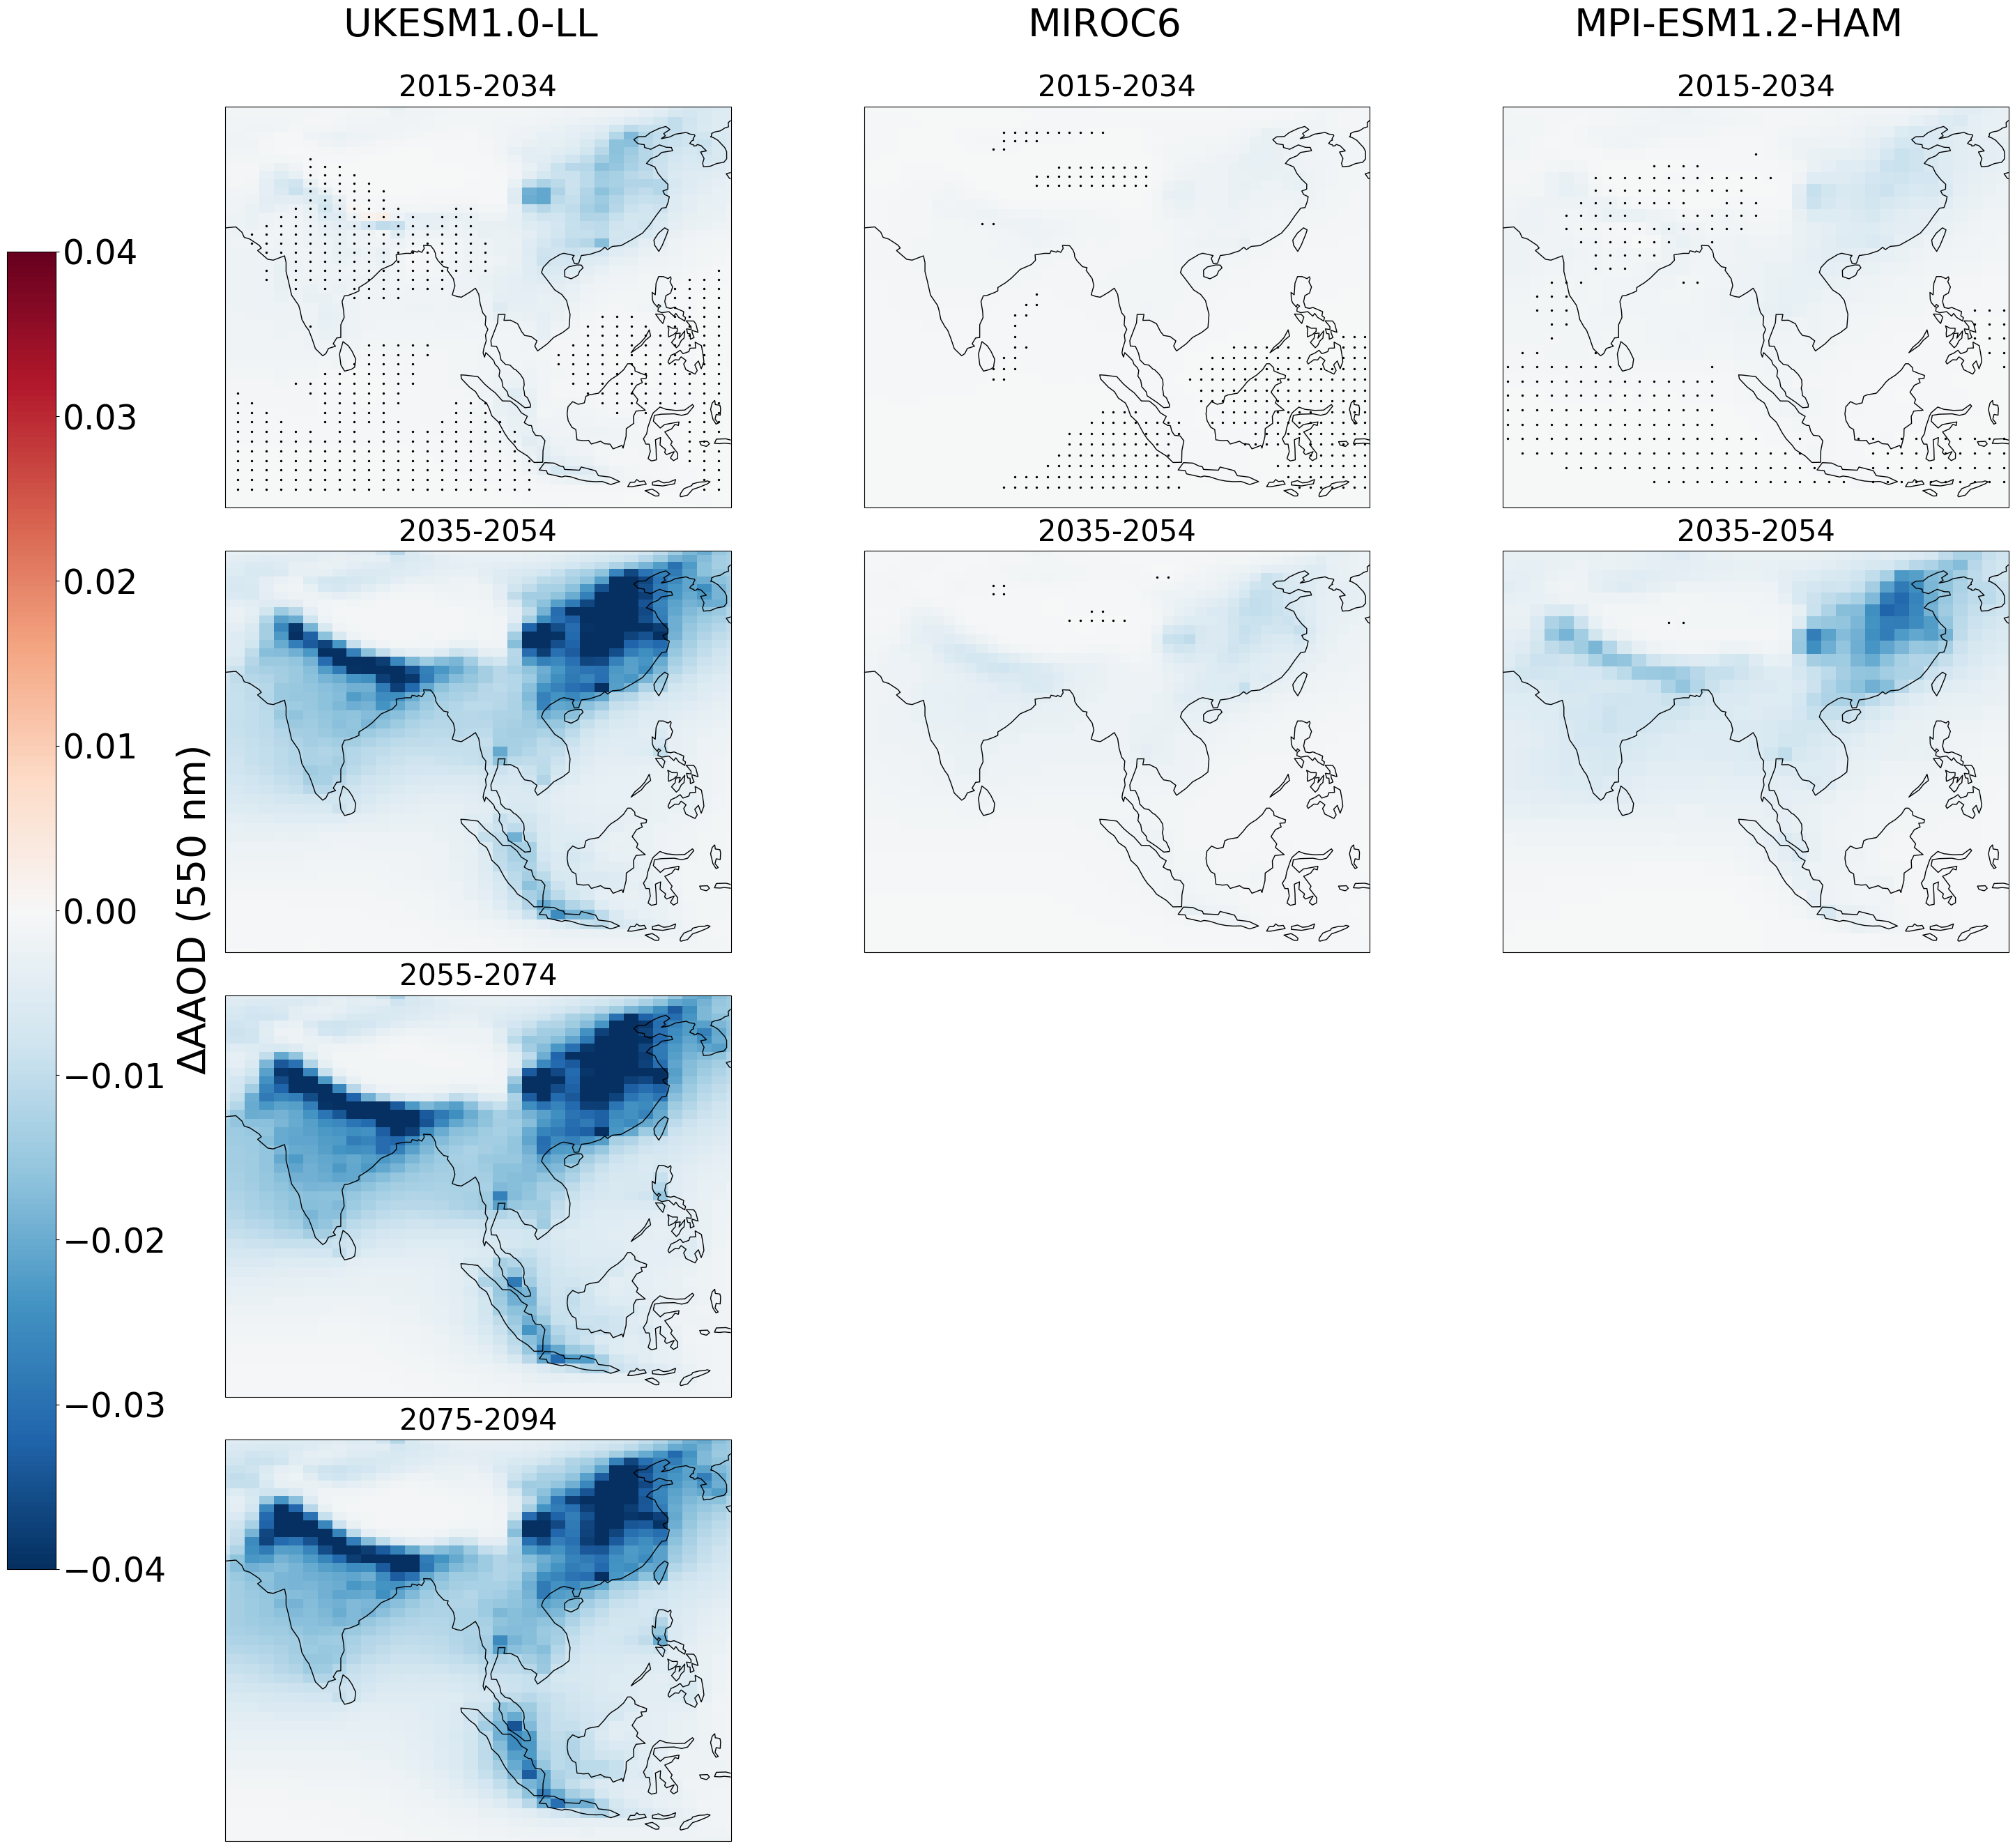

In [12]:
# Create the grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(35, 27), subplot_kw={'projection': ccrs.LambertCylindrical()})
axes = axes.T  # Transpose to get the desired column layout

# Function to plot data
def plot_data(ax, anomaly, title, ds_base, ds_signal, start_year, end_year):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=30, pad=10)
    
    annual_means_base = calculate_annual_means(ds_base, start_year, end_year)
    annual_means_signal = calculate_annual_means(ds_signal, start_year, end_year)
    
    # Select regional data for the t-test
    regional_base = annual_means_base.sel(lon=slice(65, 130), lat=slice(-10, 40))
    regional_signal = annual_means_signal.sel(lon=slice(65, 130), lat=slice(-10, 40))
    
    t_stat, p_value = ttest_ind(regional_base['abs550aer'].values,
                                regional_signal['abs550aer'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    non_significant_points_mask = p_value >= alpha # non-significant points

    lon, lat = np.meshgrid(regional_base['lon'].values, regional_base['lat'].values)
    ax.scatter(lon[non_significant_points_mask], lat[non_significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())
    
    return im

# Plotting for each model
last_im = None
for i, (start_year, end_year) in enumerate(UKESM_intervals):
    last_im = plot_data(axes[0, i], UKESM_anomalies[i], f'{start_year}-{end_year}', UKESM_base, UKESM_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    last_im = plot_data(axes[1, i], MIROC6_anomalies[i], f'{start_year}-{end_year}', MIROC_base, MIROC_signal, start_year, end_year)

for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    last_im = plot_data(axes[2, i], MPI_ESM_anomalies[i], f'{start_year}-{end_year}', MPI_ESM_base, MPI_ESM_signal, start_year, end_year)

# Hide empty subplots for MIROC6 and MPI-ESM
for i in range(2, 4):
    fig.delaxes(axes[1, i])
    fig.delaxes(axes[2, i])

# Create the color bar with the last image
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=35)
    cbar.set_label(r'$\Delta$AAOD (550 nm)', labelpad=10, fontsize=40)
    
# Add headers for each model
header_fontsize = 40
fig.text(0.24, 0.96, 'UKESM1.0-LL', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.50, 0.96, 'MIROC6', ha='center', va='bottom', fontsize=header_fontsize)
fig.text(0.76, 0.96, 'MPI-ESM1.2-HAM', ha='center', va='bottom', fontsize=header_fontsize)

# Adjust layout
fig.tight_layout(rect=[0.11, 0, 0.9, 0.95])

plt.show()

# Season

### Define seasons

In [13]:
seasons = ['DJF', 'JJA']

### UKESM

/tmp/ipykernel_1689600/2892762589.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])


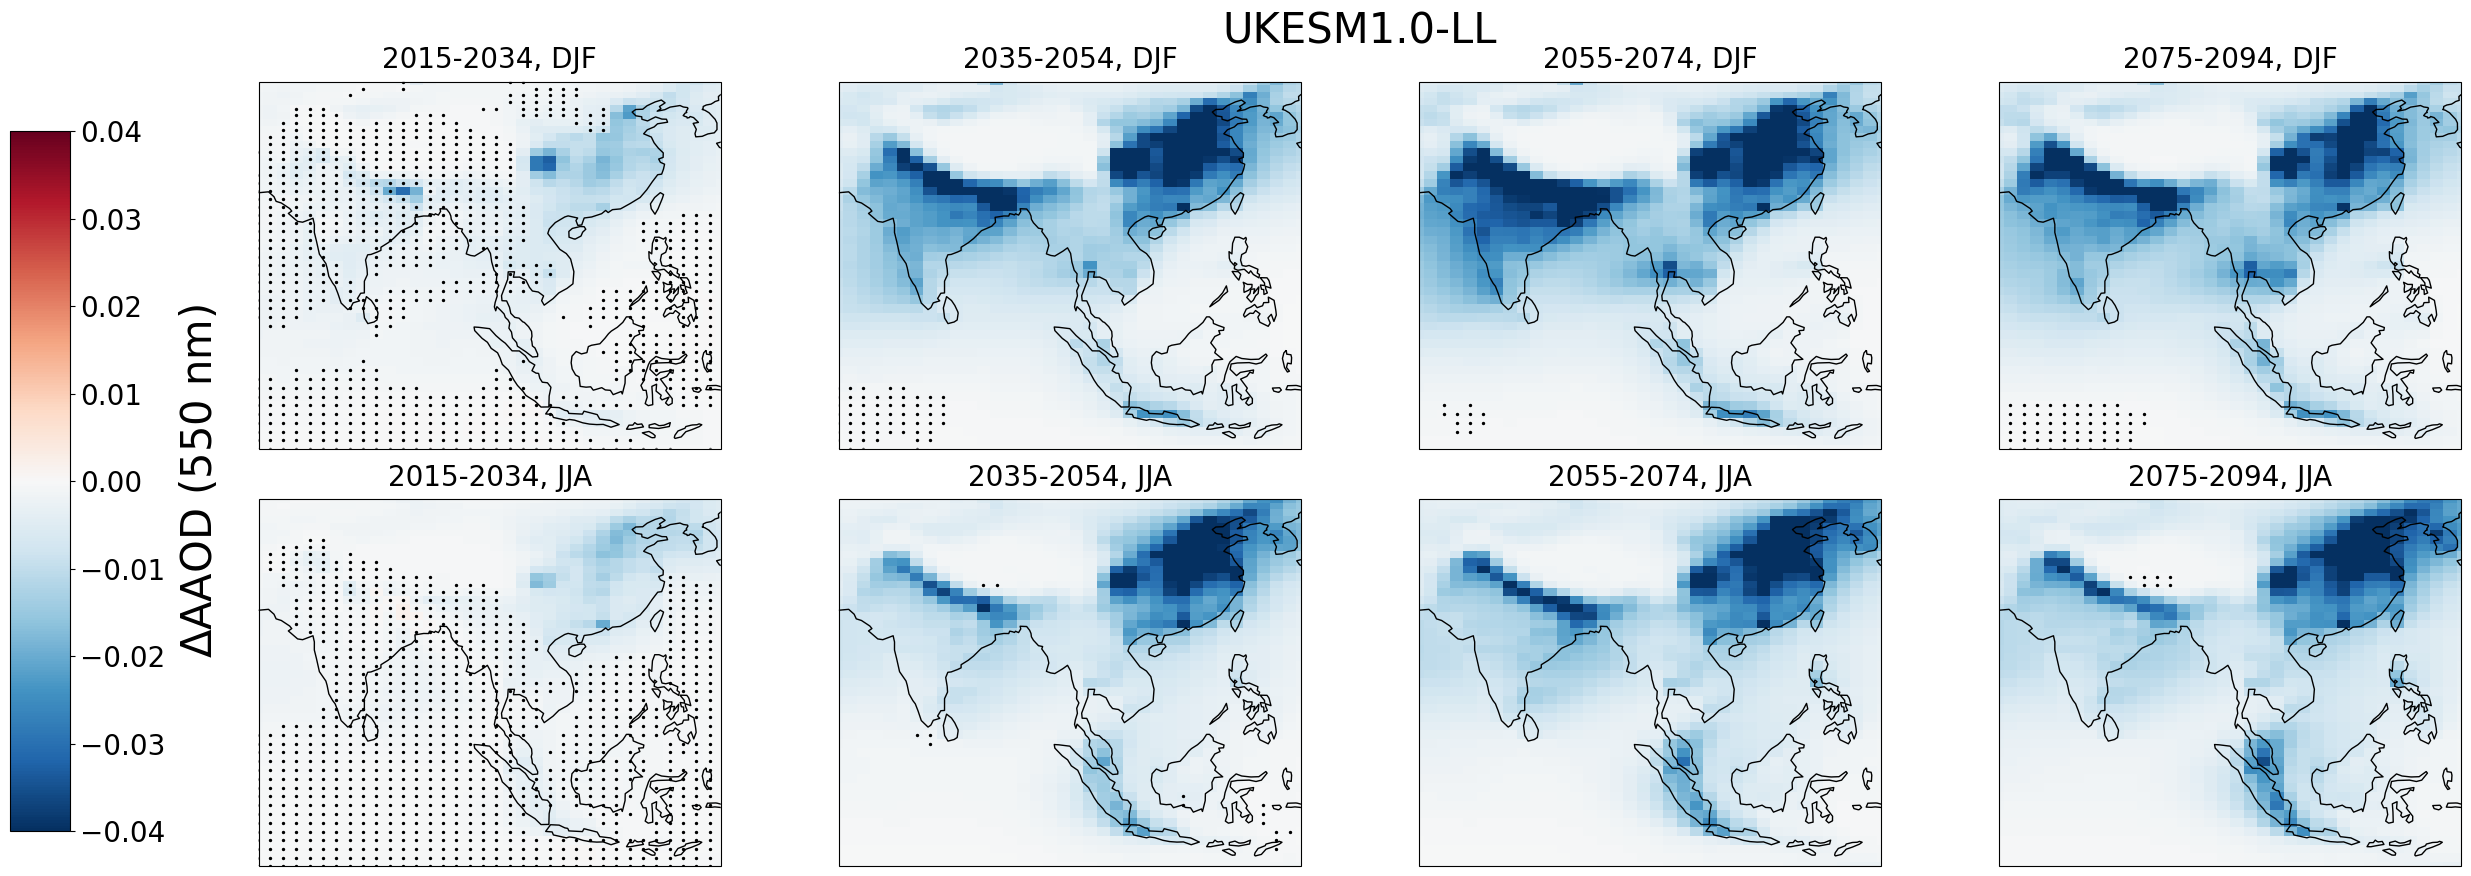

In [14]:
# Create the grid of subplots for UKESM with seasons in rows
fig, axes = plt.subplots(len(seasons), len(UKESM_intervals), figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform t-test
    t_stat, p_value = ttest_ind(seasonal_base['abs550aer'].values,
                                seasonal_signal['abs550aer'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    non_significant_points_mask = p_value >= alpha # non-significant points

    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[non_significant_points_mask], lat[non_significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

# Plotting for UKESM
last_im = None
for j, season in enumerate(seasons):
    for i, (start_year, end_year) in enumerate(UKESM_intervals):
        ax = axes[j, i]
        seasonal_base = UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=UKESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)

        # Calculate anomaly
        anomaly = calculate_seasonal_anomaly(start_year, end_year, UKESM_base, UKESM_signal, season)

        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}',
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.05, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$AAOD (550 nm)', labelpad=10, fontsize=30)

fig.text(0.50, 0.95, 'UKESM1.0-LL', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])

plt.show()


### MIROC and MPI-ESM

/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/nird/home/julnavda/conda_envs/nb-test-env/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future 

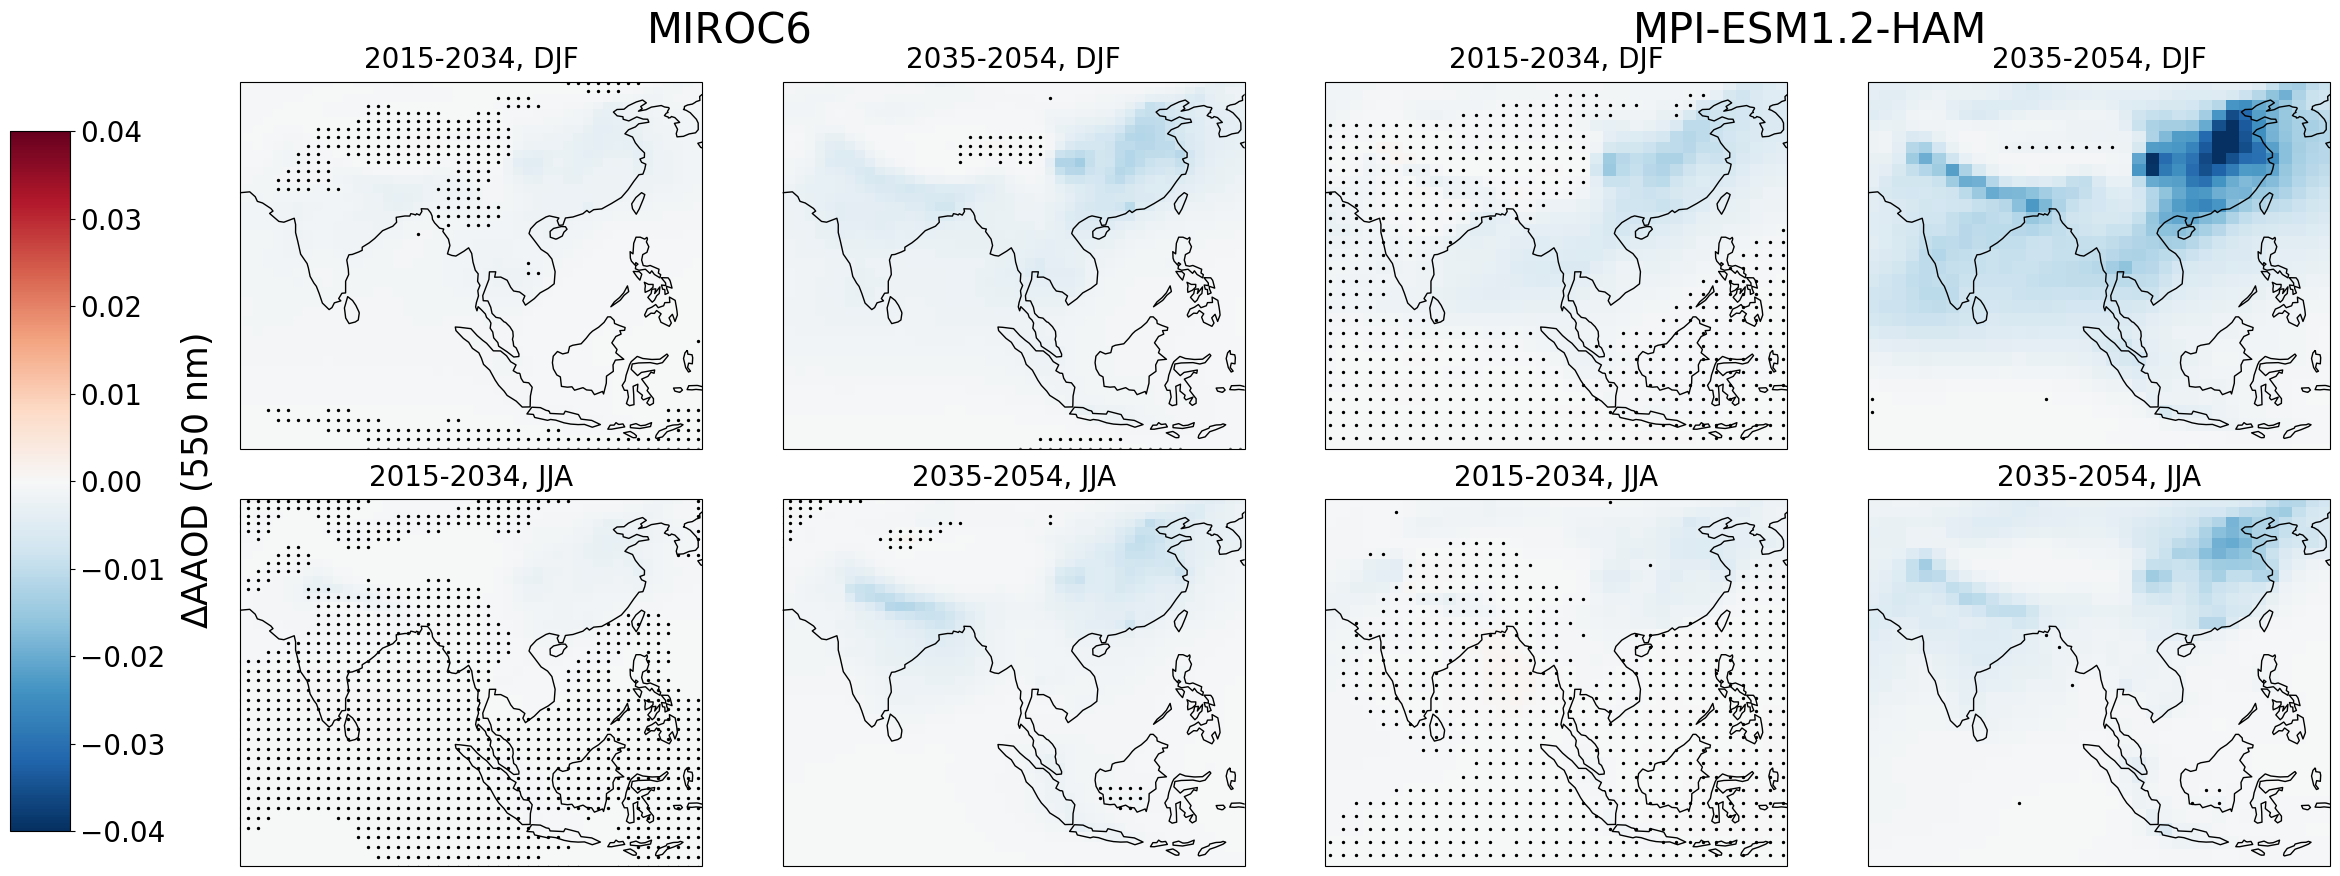

In [15]:
# Create the grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(30, 10), 
                         subplot_kw={'projection': ccrs.LambertCylindrical()})

# Flatten axes for easier indexing
axes = axes.flatten()

def plot_data(ax, anomaly, title, seasonal_base, seasonal_signal):
    # Set geographical extents [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent([65, 130, -10, 40])
    im = anomaly.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.coastlines()
    ax.set_title(title, fontsize=20, pad=10)

    # Perform the t-test
    t_stat, p_value = ttest_ind(seasonal_base['abs550aer'].values,
                                seasonal_signal['abs550aer'].values,
                                axis=0, nan_policy='omit')

    alpha = 0.05
    non_significant_points_mask = p_value >= alpha # non-significant points

    # Overlay significant points
    lon, lat = np.meshgrid(seasonal_base['lon'].values, seasonal_base['lat'].values)
    ax.scatter(lon[non_significant_points_mask], lat[non_significant_points_mask], c='k', s=2, transform=ccrs.PlateCarree())

    return im

for i, (start_year, end_year) in enumerate(MIROC6_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i]
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MIROC_base, MIROC_signal, season)
        seasonal_base = MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MIROC_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Loop through intervals and seasons for MPI-ESM
for i, (start_year, end_year) in enumerate(MPI_ESM_intervals):
    for j, season in enumerate(seasons):
        ax = axes[j * 4 + i + 2]  # Shift the index for MPI-ESM plots to the right
        anomaly = calculate_seasonal_anomaly(start_year, end_year, MPI_ESM_base, MPI_ESM_signal, season)
        seasonal_base = MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_base.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        seasonal_signal = MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30")).sel(time=MPI_ESM_signal.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-30"))['time'].dt.season == season)
        last_im = plot_data(ax, anomaly, f'{start_year}-{end_year}, {season}', 
                            seasonal_base, seasonal_signal)

# Add a color bar
if last_im is not None:
    cbar_ax = fig.add_axes([0.1, 0.15, 0.02, 0.7])  # Place on the left side
    cbar = plt.colorbar(last_im, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\Delta$AAOD (550 nm)', labelpad=10, fontsize=25)
    
# Add headers for MIROC6 and MPI-ESM1.2-HAM
fig.text(0.34, 0.95, 'MIROC6', ha='center', va='center', fontsize=30)
fig.text(0.70, 0.95, 'MPI-ESM1.2-HAM', ha='center', va='center', fontsize=30)

# Adjust layout
fig.tight_layout(rect=[0.15, 0.1, 0.9, 0.95])

plt.show()